# **Tarımsal Toprak Verimliliği Sınıflandırma Modeli**

In [ ]:
# Kurulum
!pip install -U \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    scikit-learn \
    xgboost \
    lightgbm

# **1. Gerekli Kütüphanelerin Yüklenmesi**

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Makine öğrenmesi & metrikler
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# **2. Verinin Yüklenmesi ve İlk İncelemesi**

In [152]:
df = pd.read_csv("ai-task-2.csv")

print("İlk 5 veri:\n", df.head())
print("\nVeri bilgisi:\n")
print(df.info())
print("\nVeri özet istatistiği:\n", df.describe().T)
print("\nSınıf dağılımı:\n", df['target'].value_counts())

İlk 5 veri:
    temperature   humidity  soil_moisture       rain        pH  \
0    10.151848  45.278439      23.681333  61.958795  5.668873   
1    10.165664  53.792567      12.104659  73.687374  5.319525   
2    10.208564  32.200992      28.634426   9.667645  8.027711   
3    10.275912  89.397614      48.520371  10.566468  8.172306   
4    10.325130  50.509041      50.283508  36.794075  5.371570   

   fertilizer_used  target  
0                0     0.0  
1                0     0.0  
2                0     0.0  
3                0     0.0  
4                1     0.0  

Veri bilgisi:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      500 non-null    float64
 1   humidity         500 non-null    float64
 2   soil_moisture    500 non-null    float64
 3   rain             499 non-null    float64
 4   pH               500 

# **3. Eksik ve Aykırı Değer Analizi & Özellik Mühendisliği**





**a. Eksik Değer Doldurma, Silme**

In [153]:
print("Her sütunda eksik değer sayısı:\n", df.isnull().sum())

# 'target' eksik değerini siliyoruz
df = df.dropna(subset=['target'])

# Rain eksik değerini ortalama ile dolduruyoruz
df = df.fillna(df.mean(numeric_only=True))

print("Kalan eksik değerler:\n", df.isnull().sum())

Her sütunda eksik değer sayısı:
 temperature        0
humidity           0
soil_moisture      0
rain               1
pH                 0
fertilizer_used    0
target             1
dtype: int64
Kalan eksik değerler:
 temperature        0
humidity           0
soil_moisture      0
rain               0
pH                 0
fertilizer_used    0
target             0
dtype: int64


**b. Aykırı Değer Analizi ve Baskılama**

* özellikle humidity özelliğinde outlier gözlemlenmiştir. Dolayısıyla aykırı değerleri baskılıyoruz.

In [154]:
for col in df.columns:
    if col != 'target' and df[col].dtype != 'object':
        df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))

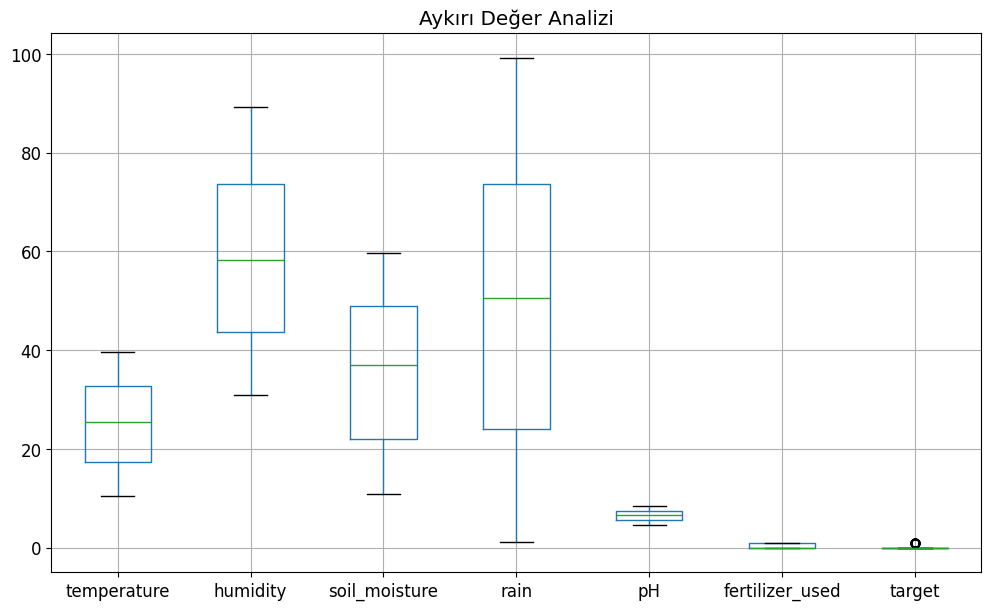

In [155]:
plt.figure(figsize=(12,7))
df.boxplot()
plt.title("Aykırı Değer Analizi")
plt.show()

**c. Özellik Mühendisliği (Feature Engineering)**

* İlk model eğitim denemelerinden sonra bazı özelliklerin değersiz, ve hedef değişken ile alakasız olduğu gözlemlendi.
* Dolayısıyla güçlü korelasyon veya özellik alternatifi oluşturmak için anlamlı ilişkiler kurarak yeni özellikler oluşturuldu.

In [156]:
df['moisture_rain_ratio'] = (df['soil_moisture'] + 1e-6) / (df['rain'] + 1e-6)
df['ph_deviation_from_optimal'] = np.abs(df['pH'] - 6.5)
df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
df['fertilizer_moisture_interaction'] = df['fertilizer_used'] * df['soil_moisture']

# **4. Dağılım ve Korelasyon Analizi**

**a. Genel Olarak Değişkenlerin Histogram Grafiklerinin İncelenmesi**

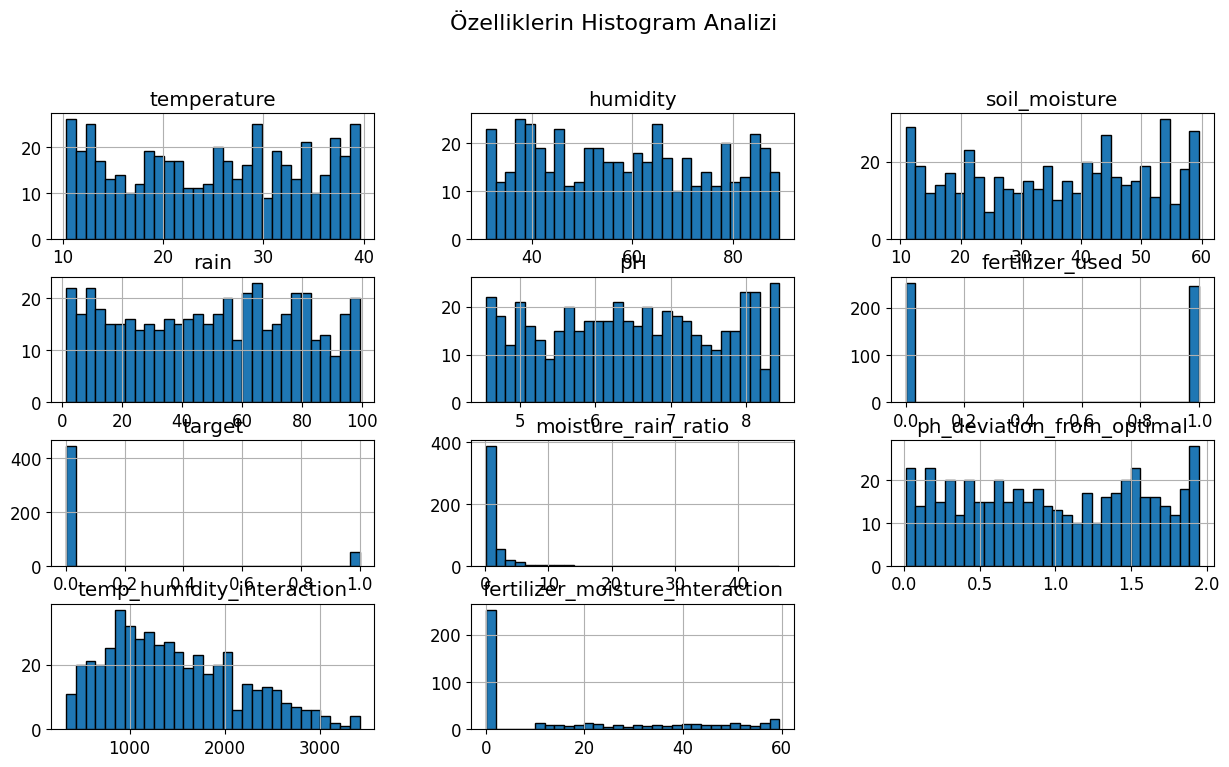

In [157]:
# Tüm değişkenlerin dağılımı
df.hist(bins=30, figsize=(15, 8), edgecolor='black')
plt.suptitle("Özelliklerin Histogram Analizi", fontsize=16, y=1.01)

plt.show()


**b. Her Özelliğin Target Özelliği ile Alaka Düzeyini Gözlemleyebileceğimiz Grafik Çizimleri**

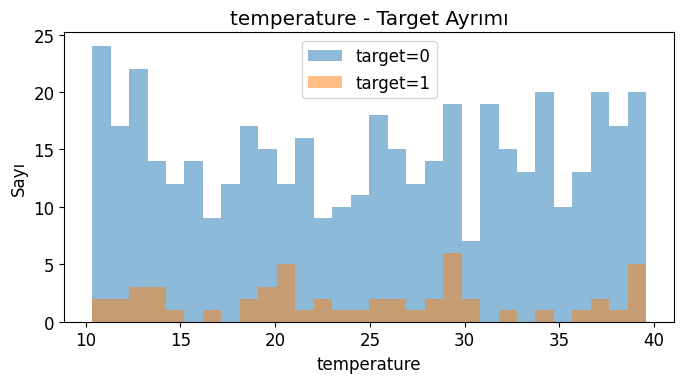

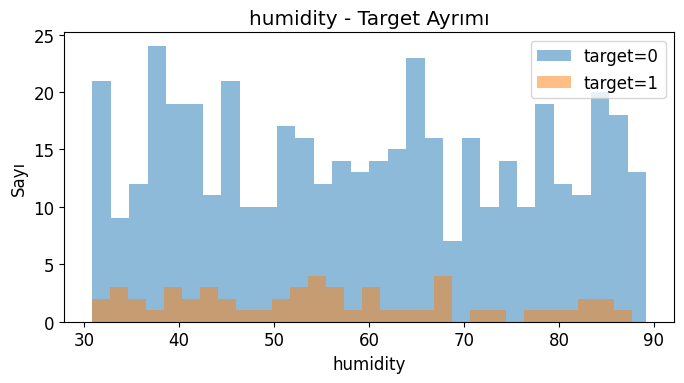

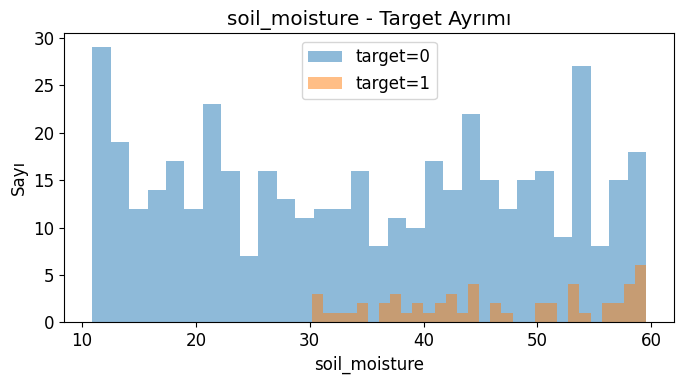

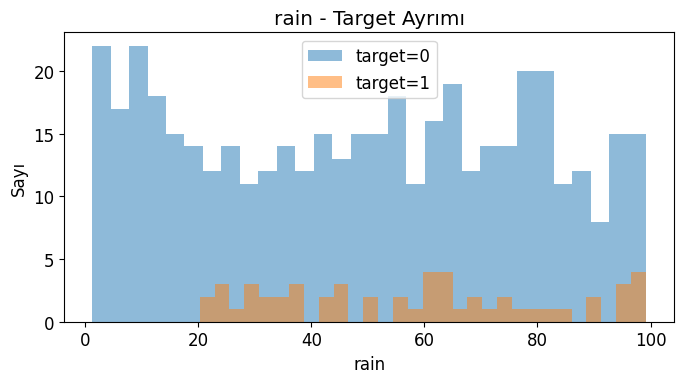

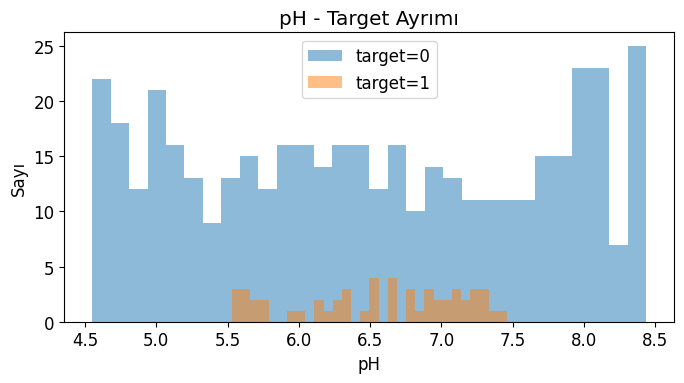

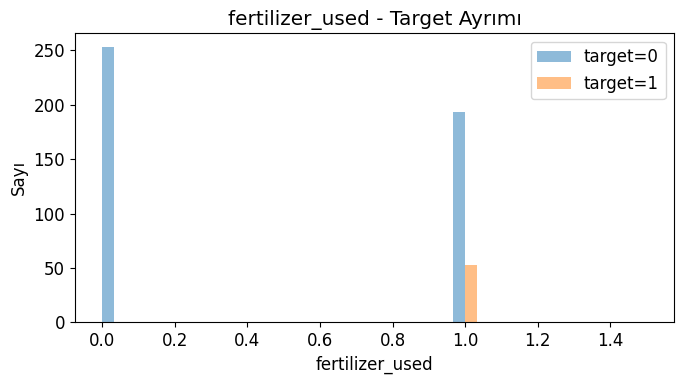

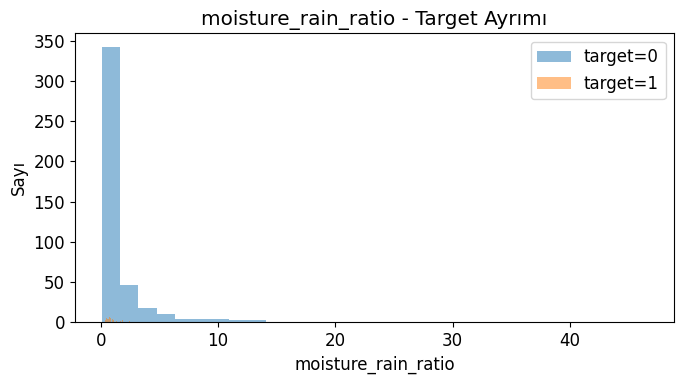

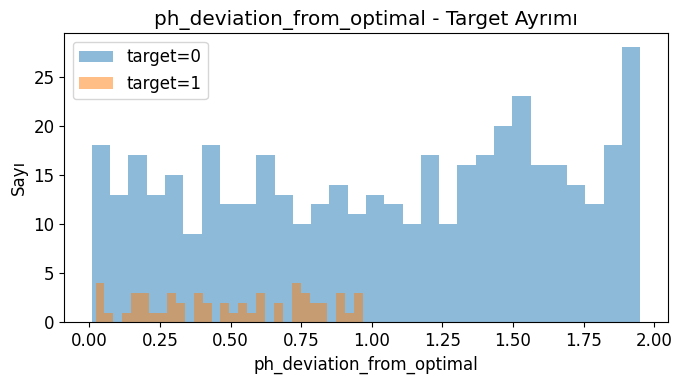

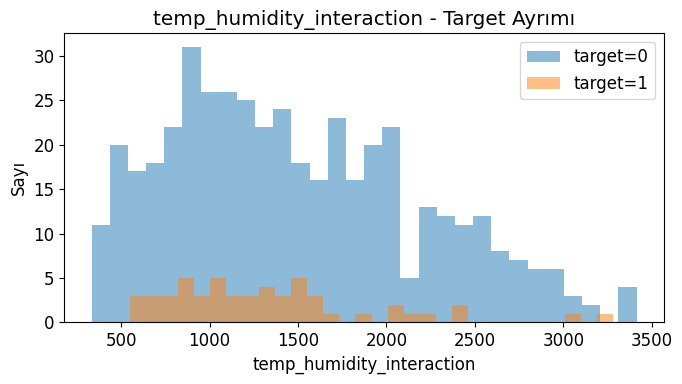

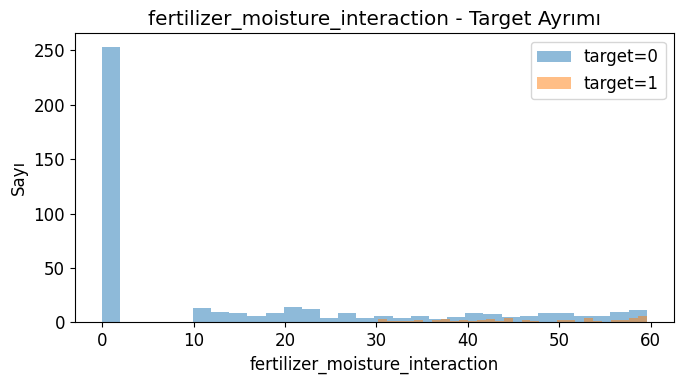

In [158]:
features = [col for col in df.columns if col != 'target']

for feature in features:
    plt.figure(figsize=(7,4))
    for label in [0, 1]:
        plt.hist(df[df['target'] == label][feature], bins=30, alpha=0.5, label=f"target={label}")
    plt.title(f"{feature} - Target Ayrımı")
    plt.xlabel(feature)
    plt.ylabel("Sayı")
    plt.legend()
    plt.tight_layout()
    plt.show()

**c. Target Özelliğinin Sınıf Dağılımı**

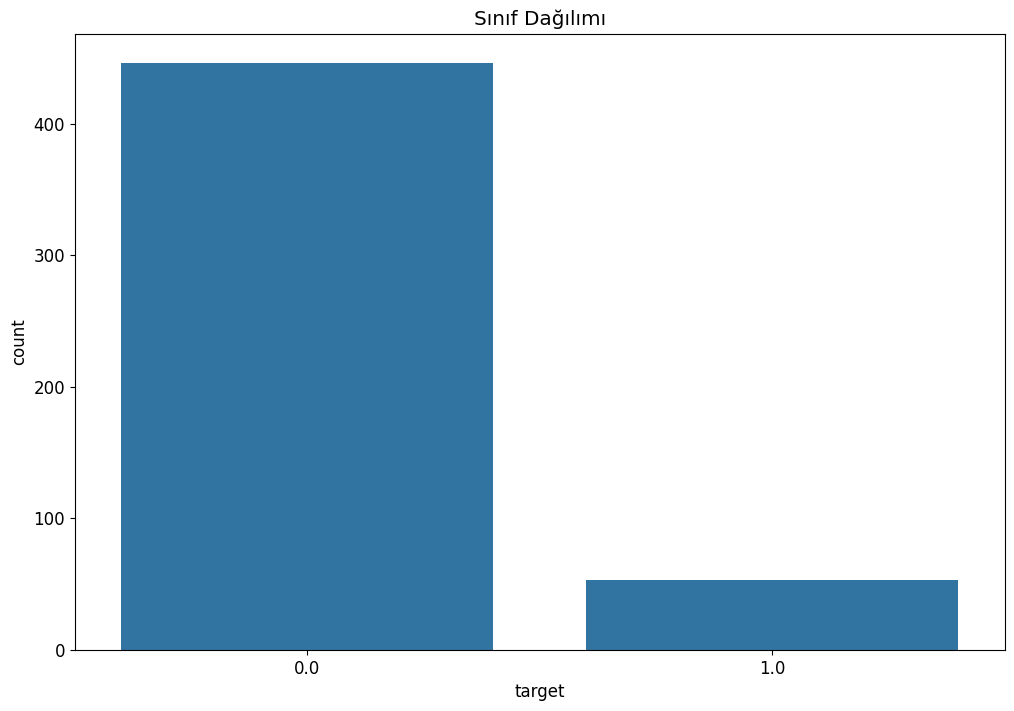

In [159]:
# verimli verimsiz dengesi
sns.countplot(x='target', data=df)
plt.title("Sınıf Dağılımı")
plt.show()

**d. Korelasyon Matrisi**

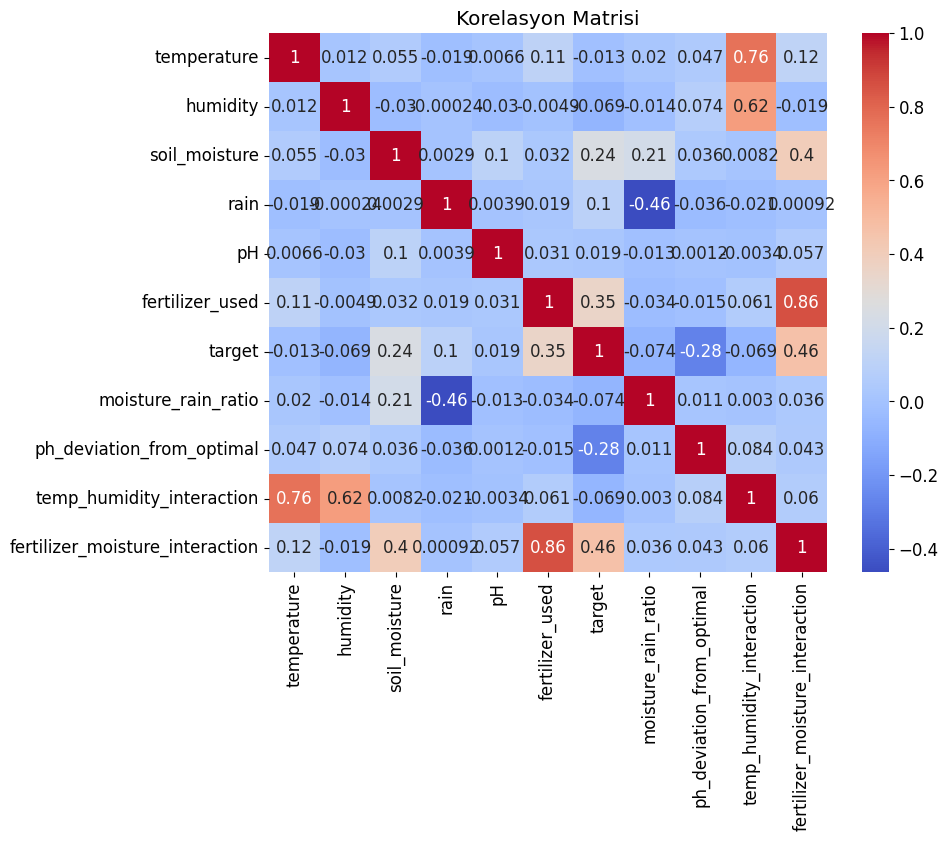

In [160]:
# Korelasyon Isı Haritası
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

**e. Target ile Korelasyon Değerlerine Göre En İyi Özellik Seçimi**

* 0.20 eşiğinin üzerindeki özellikler model için seçilir.

In [161]:
# Örnek korelasyon eşiği yaklaşımı
target_corr = abs(df.corr()['target'])
selected_features = target_corr[target_corr > 0.2].index.tolist()
selected_features.remove('target')
print("Seçilen özellikler:", selected_features)

Seçilen özellikler: ['soil_moisture', 'fertilizer_used', 'ph_deviation_from_optimal', 'fertilizer_moisture_interaction']


**Analiz ve Çıkarımlar
Veri setinin özelliklerini tek tek incelediğimde aşağıdaki önemli gözlemlere ulaştım:**

* pH Değeri:
Verimli toprakların tamamı 5.5 ile 7.5 aralığında pH değerine sahip. Ancak bu aralıktaki verimsiz toprak sayısı da oldukça fazla. Yani bu bant, verimli toprak için bir ön koşul olsa da, tek başına yeterli bir ayrım yaratmıyor.

* Sıcaklık (temperature):
Tüm sıcaklık aralıklarında hem verimli hem verimsiz toprak örnekleri mevcut. Sıcaklık değişkeni, doğrudan ayırt edici bir özellik göstermemekte.

* Nem (humidity):
Nem oranı da her iki sınıfta benzer şekilde dağılmış, bu nedenle tek başına anlamlı bir ayırt edici unsur değil.

* Toprak Nem (soil_moisture):
Verimli topraklar yalnızca soil_moisture 30'un üzerindeyken görülüyor. Ancak 30’un altında kalan topraklar kesinlikle verimsiz değil. Yani, yüksek soil_moisture verimlilik için gerekli gibi dursa da, verimliliğin garantisi değil.

* Yağış (rain):
Verimli toprak örneklerinin tamamı rain > 20 değerine sahip. Fakat bu aralığın üstünde olup yine de verimsiz olan topraklar da mevcut. Yani yağış, verimlilik için asgari bir gereklilik sunuyor olabilir.

* Gübre Kullanımı (fertilizer_used):
Verimli topraklara yalnızca gübre uygulanan örneklerde rastlanıyor. Fakat her gübre uygulanan toprak verimli çıkmamış. Gübre kullanımının etkisi diğer değişkenlerle beraber ele alınmalı.

* is_ph_neutral (Türev Özellik):
Verimli topraklar sadece nötr pH aralığında oluşmuş durumda fakat bütün nötr pH değerindeki topraklar verimli değil.

**Korelasyona göre seçilen özellikler**

---

In [162]:
df = df[[
    'soil_moisture', 'fertilizer_used', 'ph_deviation_from_optimal', 'fertilizer_moisture_interaction', 'target'
]]

# **5. Veri Hazırlama (Eğitim-Test Ayrımı & Ölçekleme)**



In [163]:
X = df.drop('target', axis=1)
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **6. Model Eğitimi**

**a. Standart bölme işlemi ile model eğitimi**

---
* Başta model eğitimini bu şekilde gerçekleştirmiş olsam da, model çok iyi sonuçlar vermesinden dolayı overfitting olduğunu düşünerek başka bir yöntem seçme kararı aldım ve yine doküman olarak kalsın maksadıyla yorum satırına dönüştürdüm.

In [ ]:
# model_list = [
#     ('Random Forest', RandomForestClassifier(random_state=1)),
#     ('XGBoost', XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss')),
#     ('Logistic Regression', LogisticRegression(random_state=1)),
#     ('SVC', SVC(probability=True, random_state=42)),
#     ('KNN', KNeighborsClassifier()),
#     ('Decision Tree', DecisionTreeClassifier(random_state=42)),
#     ('LightGBM', LGBMClassifier(random_state=42)),
#     ('MLP', MLPClassifier(random_state=42, max_iter=300))
# ]

# results = []
# for name, model in model_list:
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     if hasattr(model, "predict_proba"):
#         y_proba = model.predict_proba(X_test_scaled)[:,1]
#     elif hasattr(model, "decision_function"):
#         from scipy.special import expit
#         y_proba = expit(model.decision_function(X_test_scaled))
#     else:
#         y_proba = y_pred
#     results.append({
#         'Model': name,
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred, zero_division=0),
#         'Recall': recall_score(y_test, y_pred),
#         'F1': f1_score(y_test, y_pred),
#         'AUC': roc_auc_score(y_test, y_proba)
#     })
# results_df_simple = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
# print("\n---Standart Holdout Test Sonuçları---\n")
# print(results_df_simple)

**- Model Karşılaştırma Grafiği**

---

In [ ]:
# plt.figure(figsize=(10,5))
# for col in ['Accuracy', 'F1', 'AUC']:
#     plt.plot(results_df_simple['Model'], results_df_simple[col], marker='o', label=col)
# plt.title("Modellerin Holdout (standart split) Performansı")
# plt.ylabel("Değer")
# plt.xticks(rotation=30)
# plt.legend()
# plt.tight_layout()
# plt.show()

**- En İyi Parametrelerin Listesi (GridSearchCV)**

---

* Parametreler daha öncesinde GridSearchCV kullanılarak en iyi skor veren parametreler otomatik bulunmuştur.
* Veri setini de düşünerek en iyi parametrelerin bulunması modeller için en iyi sonuçları vermesini sağlayacağı için GridSearchCV kullanılmıştır.
* GridSearcCv'nin çapraz doğrulaması (cv=5) sayesinde overfitting riskini azaltır.

In [164]:
model_list = [
    # 1) Random Forest
    ('Random Forest',
     RandomForestClassifier(
         random_state      = 42,
         n_estimators      = 100,
         max_depth         = 10,
         min_samples_leaf  = 1,
         class_weight      = 'balanced'
     )),

    # 2) XGBoost
    ('XGBoost',
     XGBClassifier(
         random_state       = 42,
         use_label_encoder  = False,
         eval_metric        = 'logloss',
         n_estimators       = 100,
         learning_rate      = 0.01,
         max_depth          = 5,
         subsample          = 0.7,
         colsample_bytree   = 1.0,
         scale_pos_weight   = 8.5
     )),

    # 3) Logistic Regression
    ('Logistic Regression',
     LogisticRegression(
         random_state  = 42,
         max_iter      = 500,
         C             = 1,
         penalty       = 'l2',
         solver        = 'liblinear',
         class_weight  = 'balanced'
     )),

    # 4) SVC (SVM)
    ('SVC',
     SVC(
         random_state   = 42,
         probability    = True,
         C              = 50,
         kernel         = 'rbf',
         gamma          = 'scale',
         class_weight   = None
     )),

    # 5) K-Nearest Neighbours
    ('KNN',
     KNeighborsClassifier(
         n_neighbors = 11,
         weights     = 'uniform',
         metric      = 'manhattan'
     )),

    # 6) Decision Tree
    ('Decision Tree',
     DecisionTreeClassifier(
         random_state      = 42,
         criterion         = 'gini',
         max_depth         = 5,
         min_samples_leaf  = 4,
         class_weight      = None
     )),

    # 7) LightGBM
    ('LightGBM',
     LGBMClassifier(
         random_state       = 42,
         n_estimators       = 100,
         learning_rate      = 0.01,
         max_depth          = -1,
         num_leaves         = 15,
         subsample          = 0.7,
         colsample_bytree   = 0.7,
         class_weight       = 'balanced',
         objective          = 'binary'
     )),

    # 8) Multi-layer Perceptron
    ('MLP',
     MLPClassifier(
         random_state          = 42,
         max_iter              = 300,
         hidden_layer_sizes    = (50, 50),
         activation            = 'tanh',
         alpha                 = 0.01,
         learning_rate         = 'constant'
     ))
]

**b. K-Fold Cross Validation ile Model Eğitimi**

---

* Kullanılan yöntem: StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
* Her fold da sınıf oranı korunur.
* 5 bölüm, veri seti için uygun bias-variance dengesi.
* Sızıntı (data-leak) engeli için scaler her fold içinde fit edildi.


In [166]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in model_list:
    metrics = {'accuracy': [], 'precision': [], 'recall': [],
               'f1': [], 'roc_auc': []}

    for train_idx, test_idx in kfold.split(X, y):
        # Ayrım
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Standart ölçeklendirme (tüm modellerde tutarlılık için)
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_test_fold_scaled  = scaler.transform(X_test_fold)

        # Eğitim
        model.fit(X_train_fold_scaled, y_train_fold)

        # Tahmin
        y_pred = model.predict(X_test_fold_scaled)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_fold_scaled)[:, 1]
        elif hasattr(model, "decision_function"):
            from scipy.special import expit
            y_proba = expit(model.decision_function(X_test_fold_scaled))


        # Met­rikler
        metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
        metrics['precision'].append(precision_score(y_test_fold, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test_fold, y_pred))
        metrics['f1'].append(f1_score(y_test_fold, y_pred))
        metrics['roc_auc'].append(roc_auc_score(y_test_fold, y_proba))

    # K-fold ortalamalarını kaydet
    results.append({
        'Model': name,
        'Accuracy Mean':  np.mean(metrics['accuracy']),
        'Accuracy Std':   np.std(metrics['accuracy']),
        'Precision Mean': np.mean(metrics['precision']),
        'Recall Mean':    np.mean(metrics['recall']),
        'F1 Mean':        np.mean(metrics['f1']),
        'ROC AUC Mean':   np.mean(metrics['roc_auc'])
    })

results_df_kfold = pd.DataFrame(results)\
                     .sort_values('ROC AUC Mean', ascending=False)

print("\n---K-Fold Ortalama Sonuçlar (Tuned)---\n")
print(results_df_kfold)

[LightGBM] [Info] Number of positive: 43, number of negative: 356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

**-Öğrenme Eğrileri (Learning Curves)**

---
* X ekseni: Eğitim örneği sayısı (%10 → %100).
* Y ekseni: 5-fold doğrulama ROC-AUC ortalaması.

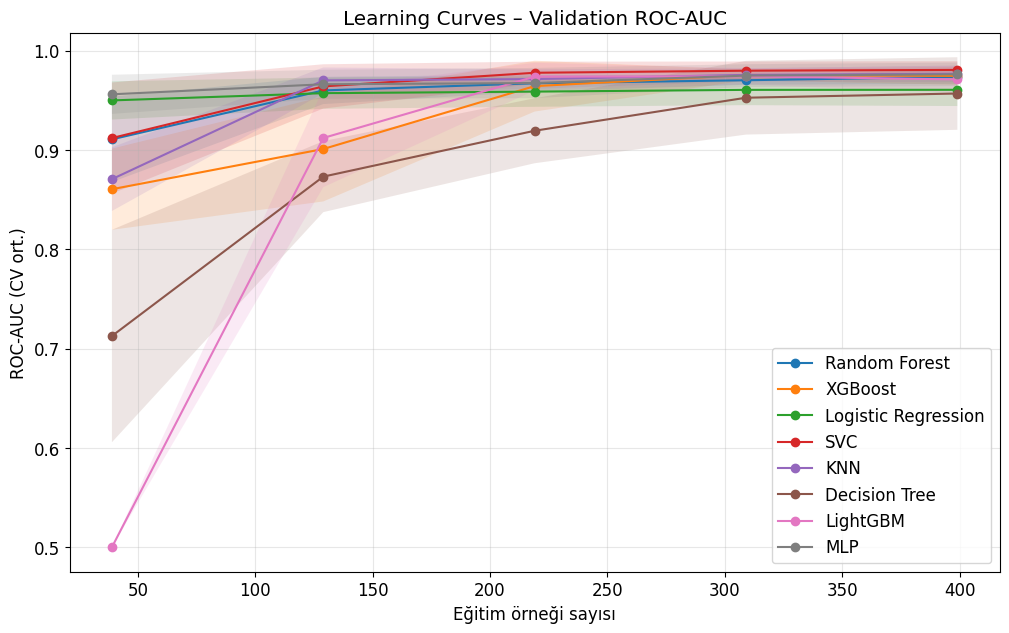

In [167]:
train_sizes = np.linspace(0.1, 1.0, 5)
cv_inner    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(12, 7))
for name, base_model in model_list:
    model = clone(base_model)

    pipe  = Pipeline([('scaler', StandardScaler()),
                      ('model',  model)])

    train_sizes_abs, train_scores, valid_scores = learning_curve(
        pipe, X, y,
        train_sizes=train_sizes,
        cv=cv_inner,
        scoring='roc_auc',
        n_jobs=-1
    )

    valid_mean = valid_scores.mean(axis=1)
    valid_std  = valid_scores.std(axis=1)

    plt.plot(train_sizes_abs, valid_mean, marker='o', label=name)
    plt.fill_between(train_sizes_abs,
                     valid_mean - valid_std,
                     valid_mean + valid_std,
                     alpha=0.15)

plt.title('Learning Curves – Validation ROC-AUC')
plt.xlabel('Eğitim örneği sayısı')
plt.ylabel('ROC-AUC (CV ort.)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**- Model Skor Grafiği**

---
* Çok-metrikli çizim (Accuracy, Precision, Recall, F1, ROC-AUC) tek grafikte bütün modellerin ilişkisi gözlemlendi.

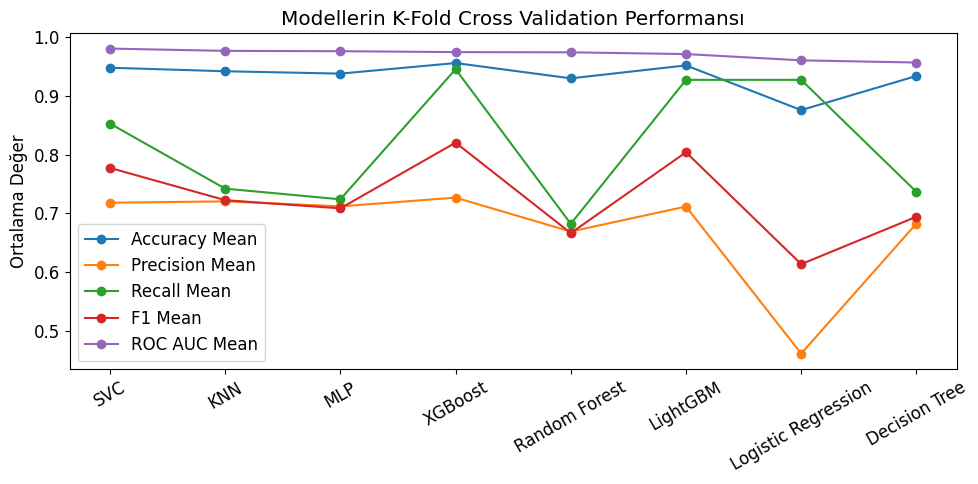

In [168]:
plt.figure(figsize=(10,5))
for col in ['Accuracy Mean', 'Precision Mean', 'Recall Mean', 'F1 Mean', 'ROC AUC Mean']:
    plt.plot(results_df_kfold['Model'], results_df_kfold[col], marker='o', label=col)
plt.title("Modellerin K-Fold Cross Validation Performansı")
plt.ylabel("Ortalama Değer")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

# **7. En İyi Modelin Seçimi ve Değerlendirmesi**




---
1.   **Metriğe Göre Model Sıralamaları**
---
* Accuracy → XGBoost (0.956) > LightGBM (0.952) > SVC (0.948)

* Precision → XGBoost (0.727) ≈ KNN (0.720) > SVC (0.718)

* Recall → XGBoost (0.945) > LightGBM / LogReg (0.927) > SVC (0.853)

* F1 → XGBoost (0.820) > LightGBM (0.804) > SVC (0.777)

* ROC-AUC → SVC (0.981) > KNN (0.977) > MLP (0.976)
---
2.   **Kararlılık(Std)**
---
Standart sapması en düşük iki model :

* LightGBM (Accuracy Std = 0.0097)

* XGBoost (Accuracy Std = 0.0102)

Bu modeller farklı katlamalarda daha tutarlı sonuç vermiş.

---
3.  **Modeller Hakkında Kısa Yorumlamalar**
---
**SVC**

* En yüksek ROC-AUC (0.981) ⇒ olası eşik ayarıyla çok iyi ayrım gücü.
* Yüksek Recall (0.853)
* – F1, XGB/LGBM’nin gerisinde; Std (0.023) nispeten yüksek.

**KNN**

* Dengeli Precision/Recall, ROC-AUC yüksek.
*  F1 ve Accuracy orta düzey. Veri boyutu arttıkça yavaş çalışır.

**MLP**

* ROC-AUC iyi, fakat Accuracy/F1 XGB ve LGBM’nin altında.
* Std en yükseklerden (0.024) ⇒ kararsız.

**XGBoost**

* Tüm temel metriklerde birinci (Accuracy, Recall, F1) veya ikinci.
* En yüksek Precision.
* Çok düşük varyans (0.010) ⇒ kararlı.
* Yorumlanabilirlik için SHAP desteği var.
* ROC-AUC, SVC’den ~0.006 puan düşük (önemsiz olabilir).

**Random Forest / Decision Tree**

* RF’nin ROC-AUC’si hâlâ 0.974 ama Precision/Recall/F1 düşük.
* Karar ağacı tek başına over-fit (ROC-AUC 0.957).

**LightGBM**

* İkinci en yüksek F1 (0.804) ve Recall (0.927).
Accuracy 0.952, varyans en düşük.
* Eğitim süresi XGB’den genelde daha kısa.
* Precision XGB/SVC’den biraz daha düşük.

**Logistic Regression**

* Basit ve hızlı, yüksek Recall (0.927).
* Precision çok düşük (0.461) ⇒ çok sayıda false-positive.
* Accuracy/F1 geride.

---
4.  **En İyi Model Seçimi**
---


* Dengeli başarı (Accuracy, Precision, Recall, F1) + kararlılık isteniyorsa XGBoost açık ara lider.

* “Yanlış negatif” (FN) maliyetli ise (en yüksek Recall) XGBoost (0.945) veya LightGBM (0.927), LR sırf Recall için uygun ama FP yüksek.

* Skor-temelli sistem kullanıyor ve eşik ayarlanacaksa (ROC-AUC odaklı) SVC (0.981) > KNN/MLP ~0.976.

* Eğitim-çıkarma hızı, RAM kısıtı varsa LightGBM (hızlı, bellek dostu, kararlı).

**Model Seçimi**

**- K-fold sonuçlarına göre:**
* XGBoost – En yüksek F1 (0.82) & Precision, en düşük varyans
* LightGBM – Yakın F1, eğitim süresi kısa, hafıza dostu
* SVC – Zirve ROC-AUC (0.981) fakat F1 ve kararlılık daha düşük

**Tarım uygulamasında verimli araziyi verimsiz sanmak maliyetli olacağından yüksek Recall değerine sahip ve dengeli Precision skoru ile XGBoost modeli tercih edildi.**


**- Seçilen Model ile Detaylı Skorlar Elde Edilir**

---
Burada seçilen modeli yeniden eğiterek detaylı verilerini inceleyenilmek istendi.


In [169]:
xgb_best_params = {
    'random_state'      : 42,
    'eval_metric'       : 'logloss',
    'n_estimators'      : 100,
    'learning_rate'     : 0.01,
    'max_depth'         : 5,
    'subsample'         : 0.7,
    'colsample_bytree'  : 1.0,
    'scale_pos_weight'  : 8.5,
    'use_label_encoder' : False
}

best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  XGBClassifier(**xgb_best_params))
])

best_model.fit(X_train, y_train)


y_pred_best  = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]


print("\nEN İYİ MODEL: XGBoost\n")
print("Test Seti Sınıflandırma Raporu (XGBoost):")
print(classification_report(y_test, y_pred_best,
                            target_names=["Verimsiz", "Verimli"]))
print("ROC-AUC (Test Seti): {:.4f}\n".format(roc_auc_score(y_test, y_proba_best)))

df = results_df_kfold

xgb_row = df.loc[df['Model'] == 'XGBoost'].squeeze()

print("5-Fold Cross-Validation Ortalama Skorları (XGBoost):")
print("Accuracy : {:.4f}".format(xgb_row['Accuracy Mean']))
print("Precision: {:.4f}".format(xgb_row['Precision Mean']))
print("Recall   : {:.4f}".format(xgb_row['Recall Mean']))
print("F1       : {:.4f}".format(xgb_row['F1 Mean']))
print("ROC-AUC  : {:.4f}".format(xgb_row['ROC AUC Mean']))


EN İYİ MODEL: XGBoost

Test Seti Sınıflandırma Raporu (XGBoost):
              precision    recall  f1-score   support

    Verimsiz       1.00      0.94      0.97        89
     Verimli       0.69      1.00      0.81        11

    accuracy                           0.95       100
   macro avg       0.84      0.97      0.89       100
weighted avg       0.97      0.95      0.95       100

ROC-AUC (Test Seti): 0.9678

5-Fold Cross-Validation Ortalama Skorları (XGBoost):
Accuracy : 0.9559
Precision: 0.7265
Recall   : 0.9455
F1       : 0.8202
ROC-AUC  : 0.9746


# **8. Model ile Tahmin Örneği**

---
* Kullanıcı arayüzü ya da sensör API'sinden gelen ham ölçümler ile çalıştırılabilir. Herhangi workflow veya arayüz oluşturulmadı fakat temelde bu adımlar izlenerek yol katedilebilir.
* Kesin 0/1 değerleri üretir.
* Ayrıca üretilen değerin doğruluk oranı da görüntülenir.

Programın genel çalışması için özet niteliğinde dışarıdan gerçek veri girdisi ile test edilebilir

In [170]:
def preprocess_sample(df):
    df = df.copy()
    df['moisture_rain_ratio'] = (df['soil_moisture'] + 1e-6) / (df['rain'] + 1e-6)
    df['ph_deviation_from_optimal'] = np.abs(df['pH'] - 6.5)
    df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
    df['fertilizer_moisture_interaction'] = df['fertilizer_used'] * df['soil_moisture']
    return df

select_features = [
    'soil_moisture', 'fertilizer_used', 'ph_deviation_from_optimal', 'fertilizer_moisture_interaction'
]

new_sample_raw = pd.DataFrame({
    'temperature'     : [10.3],
    'humidity'        : [61.1],
    'soil_moisture'   : [44.4],
    'rain'            : [64.2],
    'pH'              : [6.2],
    'fertilizer_used' : [1]
})

new_sample_fe   = preprocess_sample(new_sample_raw)
X_new           = new_sample_fe[select_features]

sample_pred  = best_model.predict(X_new)
sample_proba = best_model.predict_proba(X_new)[:, 1]

print("\nYeni örnek tahmini (0 = Verimsiz, 1 = Verimli):", int(sample_pred[0]))
print("Verimli olma olasılığı: {:.4f}".format(sample_proba[0]))


Yeni örnek tahmini (0 = Verimsiz, 1 = Verimli): 1
Verimli olma olasılığı: 0.7934


# **9. Feature Importance (Değişken Önem Analizi)**

---
* XGBoost modeline göre, model eğitiminde özelliklerin önem değerleri grafikte görüntülenmiştir.
* XGBoost modelinin özellik önem analizine göre yapılan feature engineering adımı etkili olmuş, türetilen değişkenler en üst önem seviyesinde görünmüştür.



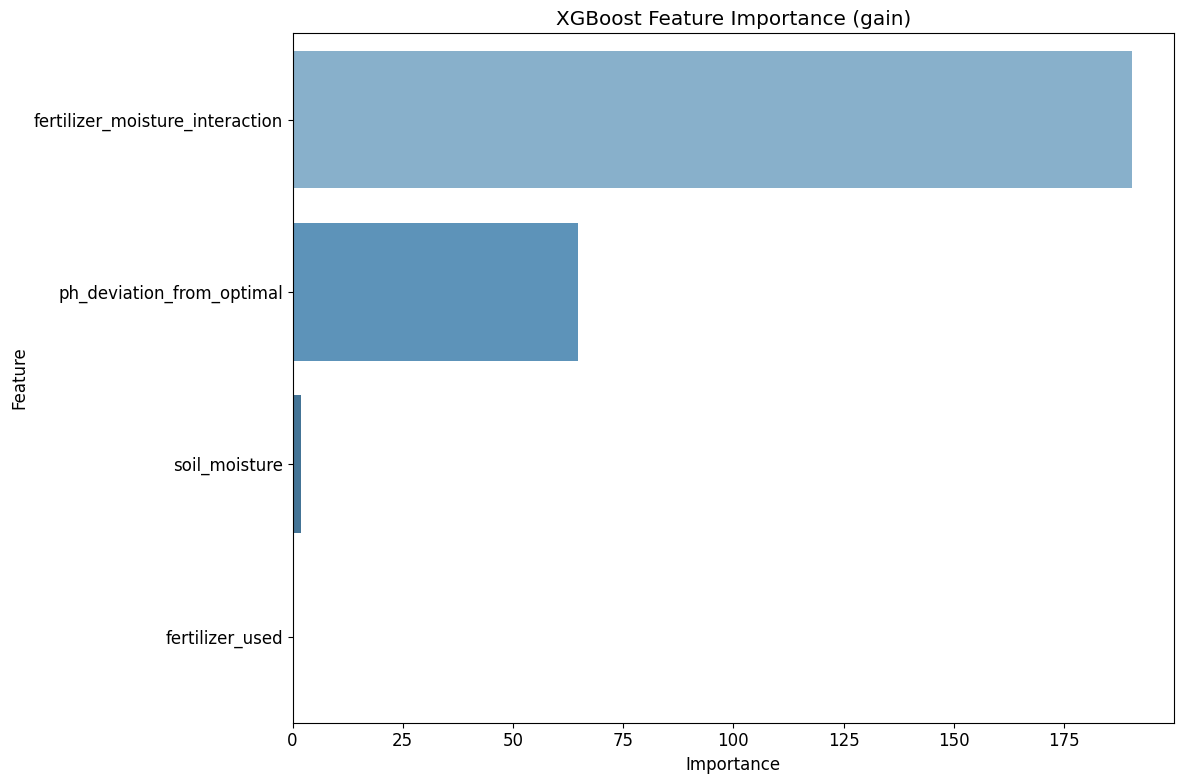

In [175]:
xgb = next(m for n, m in model_list if n == 'XGBoost')

X_scaled = StandardScaler().fit_transform(X)
xgb.fit(X_scaled, y)

gain = xgb.get_booster().get_score(importance_type='gain')
feat_names = list(X.columns)
imp = np.array([gain.get(f'f{i}', 0) for i in range(len(feat_names))])

imp_df = (pd.DataFrame({'Feature': feat_names, 'Importance': imp})
          .sort_values('Importance', ascending=False))

sns.barplot(data=imp_df, y='Feature', x='Importance', palette='Blues_d')
plt.title('XGBoost Feature Importance (gain)')
plt.tight_layout(); plt.show()

# **10. SONUÇ & DEĞERLENDİRME**

Birden fazla makine öğrenmesi modeli karşılaştırıldı. Accuracy, precision, recall, F1 ve ROC-AUC metrikleri ile model skorları ortaya çıkarıldı. Bu skorlara göre model seçimi yapıldı. Skorlara göre en iyi model XGBoost oldu.

Sorunlar ve Çözümler

---
Sınıf Dengesizliği
* class_weight='balanced'
* scale_pos_weight
* ROC-AUC odakli Metrik

Overfitting
* Straitified K-fold
* GridSearchCV ile öğrenme optimizasyonu

Düşük Özellik Sayısı, Düşük Korelasyon
* Özellik mühendisliği tekniği ile yeni özellikler türetildi
* Özellik seçimi 0.20 korelasyon eşik değerine göre yapıldı

Veri Sızıntısı (Data Leakage)
* Her fold içinde scaler fit kullanımı
* pipeline kullanımı(kısmen kullandım, overfitting olmadığı için sızıntı olmadığını düşünerek pipeline eklemedim)

Eğitim Süresi
* Parametre aralığı daraltıldı
* 'n_jobs=-1' ile paralel işlem yapıldı


